# Bulldozer Price Prediction Model
<span style='color:red'>**Note:** On the next linsem, we are goin to work on filling the missing data before splitting it into training and validation sets. The correct way it is split data before make any adjustment.</span>

![](../zero-to-mastery-ml/images/ml101-steps-to-take-in-a-machine-learning-project.png)

In this notebook we are going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

In [1]:
# Import all the tools we need 
import expectexception
import warnings

# Regular EDA (Exploratory Data Analysis) and plotting libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# Machine learning model
from sklearn.ensemble import RandomForestRegressor

# Model evaluation
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, r2_score

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
import sys
!conda install --yes --prefix {sys.prefix} openpyxl

Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done


In [3]:
# Set the environment setup
# Setting the configuration
%matplotlib inline

SEED = 42

sns.set()
plt_params = {'axes.titlesize':'10',
              'xtick.labelsize':'8',
              'ytick.labelsize':'8',
              'axes.labelsize': '8',
              'legend.fontsize': '8'}
rcParams.update(plt_params)
# # To retunr to default
# plt.style.use('default')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## 1. Problem definition
> How well we can predict the future sale price of a bulldozers, given their charactheristics and previous examples of how much similar bulldozers have been sold.


## 2. Data

Source: https://www.kaggle.com/competitions/bluebook-for-bulldozers

The data is split into three parts:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

In [4]:
# typeWarning: Columns (13,39,40,41) have mixed types. 
# Specify dtype option on import or set low_memory=False.
df = pd.read_csv('data/Train.zip', compression='zip', low_memory=False, parse_dates=['saledate'])
df.head()

SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1139246      66000     999089     3157         121           3.0      2004   
1  1139248      57000     117657       77         121           3.0      1996   
2  1139249      10000     434808     7009         121           3.0      2001   
3  1139251      38500    1026470      332         121           3.0      2001   
4  1139253      11000    1057373    17311         121           3.0      2007   

   MachineHoursCurrentMeter UsageBand   saledate fiModelDesc fiBaseModel  \
0                      68.0       Low 2006-11-16        521D         521   
1                    4640.0       Low 2004-03-26      950FII         950   
2                    2838.0      High 2004-02-26         226         226   
3                    3486.0      High 2011-05-19    PC120-6E       PC120   
4                     722.0    Medium 2009-07-23        S175        S175   

  fiSecondaryDesc fiModelSeries fiModelDescriptor ProductSize  \
0               D           NaN               NaN         NaN   
1               F            II               NaN      Medium   
2             NaN           NaN               NaN         NaN   
3             NaN           -6E               NaN       Small   
4             NaN           NaN               NaN         NaN   

                                           fiProductClassDesc           state  \
0                    Wheel Loader - 110.0 to 120.0 Horsepower         Alabama   
1                    Wheel Loader - 150.0 to 175.0 Horsepower  North Carolina   
2  Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity        New York   
3       Hydraulic Excavator, Track - 12.0 to 14.0 Metric Tons           Texas   
4  Skid Steer Loader - 1601.0 to 1751.0 Lb Operating Capacity        New York   

  ProductGroup    ProductGroupDesc Drive_System   Enclosure  \
0           WL        Wheel Loader          NaN  EROPS w AC   
1           WL        Wheel Loader          NaN  EROPS w AC   
2          SSL  Skid Steer Loaders          NaN       OROPS   
3          TEX    Track Excavators          NaN  EROPS w AC   
4          SSL  Skid Steer Loaders          NaN       EROPS   

                 Forks Pad_Type         Ride_Control Stick Transmission  \
0  None or Unspecified      NaN  None or Unspecified   NaN          NaN   
1  None or Unspecified      NaN  None or Unspecified   NaN          NaN   
2  None or Unspecified      NaN                  NaN   NaN          NaN   
3                  NaN      NaN                  NaN   NaN          NaN   
4  None or Unspecified      NaN                  NaN   NaN          NaN   

  Turbocharged Blade_Extension Blade_Width Enclosure_Type Engine_Horsepower  \
0          NaN             NaN         NaN            NaN               NaN   
1          NaN             NaN         NaN            NaN               NaN   
2          NaN             NaN         NaN            NaN               NaN   
3          NaN             NaN         NaN            NaN               NaN   
4          NaN             NaN         NaN            NaN               NaN   

  Hydraulics Pushblock Ripper Scarifier Tip_Control            Tire_Size  \
0    2 Valve       NaN    NaN       NaN         NaN  None or Unspecified   
1    2 Valve       NaN    NaN       NaN         NaN                 23.5   
2  Auxiliary       NaN    NaN       NaN         NaN                  NaN   
3    2 Valve       NaN    NaN       NaN         NaN                  NaN   
4  Auxiliary       NaN    NaN       NaN         NaN                  NaN   

               Coupler       Coupler_System       Grouser_Tracks  \
0  None or Unspecified                  NaN                  NaN   
1  None or Unspecified                  NaN                  NaN   
2  None or Unspecified  None or Unspecified  None or Unspecified   
3  None or Unspecified                  NaN                  NaN   
4  None or Unspecified  None or Unspecified  None or Unspecified   

  Hydrauli

In [5]:
df_test = pd.read_csv('data/Test.csv', low_memory=False, parse_dates=['saledate'])
df_test.head(2)

SalesID  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1227829    1006309     3168         121             3      1999   
1  1227844    1022817     7271         121             3      1000   

   MachineHoursCurrentMeter UsageBand   saledate fiModelDesc fiBaseModel  \
0                    3688.0       Low 2012-05-03        580G         580   
1                   28555.0      High 2012-05-10         936         936   

  fiSecondaryDesc fiModelSeries fiModelDescriptor ProductSize  \
0               G           NaN               NaN         NaN   
1             NaN           NaN               NaN      Medium   

                                        fiProductClassDesc     state  \
0  Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth   Wyoming   
1                 Wheel Loader - 135.0 to 150.0 Horsepower  Virginia   

  ProductGroup ProductGroupDesc     Drive_System Enclosure Forks  \
0           BL  Backhoe Loaders  Two Wheel Drive     OROPS   Yes   
1           WL     Wheel Loader              NaN     EROPS   Yes   

              Pad_Type         Ride_Control     Stick Transmission  \
0  None or Unspecified                   No  Standard     Standard   
1                  NaN  None or Unspecified       NaN          NaN   

          Turbocharged Blade_Extension Blade_Width Enclosure_Type  \
0  None or Unspecified             NaN         NaN            NaN   
1                  NaN             NaN         NaN            NaN   

  Engine_Horsepower Hydraulics Pushblock Ripper Scarifier Tip_Control  \
0               NaN        NaN       NaN    NaN       NaN         NaN   
1               NaN    2 Valve       NaN    NaN       NaN         NaN   

  Tire_Size              Coupler Coupler_System Grouser_Tracks  \
0       NaN                  NaN            NaN            NaN   
1      20.5  None or Unspecified            NaN            NaN   

  Hydraulics_Flow Track_Type Undercarriage_Pad_Width Stick_Length Thumb  \
0             NaN        NaN                     NaN          NaN   NaN   
1             NaN        NaN                     NaN          NaN   NaN   

  Pattern_Changer Grouser_Type Backhoe_Mounting Blade_Type Travel_Controls  \
0             NaN          NaN              NaN        NaN             NaN   
1             NaN          NaN              NaN        NaN             NaN   

  Differential_Type Steering_Controls  
0               NaN               NaN  
1          Standard      Conventional

In [6]:
df_valid = pd.read_csv('data/Valid.csv', low_memory=False, parse_dates=['saledate'])
df_valid.head(2)

SalesID  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1222837     902859     1376         121             3      1000   
1  1222839    1048320    36526         121             3      2006   

   MachineHoursCurrentMeter UsageBand   saledate fiModelDesc fiBaseModel  \
0                       0.0       NaN 2012-01-05        375L         375   
1                    4412.0    Medium 2012-01-05    TX300LC2       TX300   

  fiSecondaryDesc fiModelSeries fiModelDescriptor     ProductSize  \
0             NaN           NaN                 L  Large / Medium   
1              LC             2               NaN  Large / Medium   

                                      fiProductClassDesc        state  \
0  Hydraulic Excavator, Track - 66.0 to 90.0 Metric Tons     Kentucky   
1  Hydraulic Excavator, Track - 28.0 to 33.0 Metric Tons  Connecticut   

  ProductGroup  ProductGroupDesc Drive_System   Enclosure Forks Pad_Type  \
0          TEX  Track Excavators          NaN       EROPS   NaN      NaN   
1          TEX  Track Excavators          NaN  EROPS w AC   NaN      NaN   

  Ride_Control Stick Transmission Turbocharged Blade_Extension Blade_Width  \
0          NaN   NaN          NaN          NaN             NaN         NaN   
1          NaN   NaN          NaN          NaN             NaN         NaN   

  Enclosure_Type Engine_Horsepower Hydraulics Pushblock Ripper Scarifier  \
0            NaN               NaN   Standard       NaN    NaN       NaN   
1            NaN               NaN  Auxiliary       NaN    NaN       NaN   

  Tip_Control Tire_Size              Coupler Coupler_System Grouser_Tracks  \
0         NaN       NaN  None or Unspecified            NaN            NaN   
1         NaN       NaN            Hydraulic            NaN            NaN   

  Hydraulics_Flow Track_Type Undercarriage_Pad_Width         Stick_Length  \
0             NaN      Steel     None or Unspecified  None or Unspecified   
1             NaN      Steel     None or Unspecified               12' 4"   

                 Thumb      Pattern_Changer Grouser_Type Backhoe_Mounting  \
0  None or Unspecified  None or Unspecified       Double              NaN   
1  None or Unspecified                  Yes       Double              NaN   

  Blade_Type Travel_Controls Differential_Type Steering_Controls  
0        NaN             NaN               NaN               NaN  
1        NaN             NaN               NaN               NaN

## 3. Evaluation

The evaluation metric is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

> **Note:** The goal for most regression evaluation metrics is to minimize the error, in this case, minimize the RMSLE.<br>
> Output format should contain two columns:
>* SalesID: SalesID for the validation set in sorted order
>* SalePrice: Your predicted price of the sale

## 4. Features

We have the following dictionary of the data

In [7]:
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')
data_dictionary = pd.read_excel('data/Data Dictionary.xlsx', na_filter=False)
data_dictionary.columns = ['Feature', 'Description', 'Comments']
warnings.simplefilter("default")
data_dictionary

Feature  \
0                    SalesID   
1                  MachineID   
2                    ModelID   
3                 datasource   
4               auctioneerID   
5                   YearMade   
6   MachineHoursCurrentMeter   
7                  UsageBand   
8                   Saledate   
9                  Saleprice   
10               fiModelDesc   
11               fiBaseModel   
12           fiSecondaryDesc   
13             fiModelSeries   
14         fiModelDescriptor   
15               ProductSize   
16          ProductClassDesc   
17                     State   
18              ProductGroup   
19          ProductGroupDesc   
20              Drive_System   
21                 Enclosure   
22                     Forks   
23                  Pad_Type   
24              Ride_Control   
25                     Stick   
26              Transmission   
27              Turbocharged   
28           Blade_Extension   
29               Blade_Width   
30            Enclosure_Type   
31         Engine_Horsepower   
32                Hydraulics   
33                 Pushblock   
34                    Ripper   
35                 Scarifier   
36               Tip_control   
37                 Tire_Size   
38                   Coupler   
39            Coupler_System   
40            Grouser_Tracks   
41           Hydraulics_Flow   
42                Track_Type   
43   Undercarriage_Pad_Width   
44              Stick_Length   
45                     Thumb   
46           Pattern_Changer   
47              Grouser_Type   
48          Backhoe_Mounting   
49                Blade_Type   
50           Travel_Controls   
51         Differential_Type   
52         Steering_Controls   

                                                                                                                                                                                                                        Description  \
0                                                                                                                                                                    unique identifier of a particular sale of a machine at auction   
1                                                                                                                                                            identifier for a particular machine;  machines may have multiple sales   
2                                                                                                                                                                          identifier for a unique machine model (i.e. fiModelDesc)   
3                                        source of the sale record;  some sources are more diligent about reporting attributes of the machine than others.  Note that a particular datasource may report on multiple auctioneerIDs.   
4                                                                                                                identifier of a particular auctioneer, i.e. company that sold the machine at auction.  Not the same as datasource.   
5                                                                                                                                                                                               year of manufacturer of the Machine   
6                                                                                                      current usage of the machine in hours at time of sale (saledate);  null or 0 means no hours have been reported for that sale   
7     value (low, medium, high) calculated comparing this particular Machine-Sale hours to average usage for the fiBaseModel;  e.g. 'Low' means this machine has less hours given it's lifespan relative to average of fiBaseModel.   
8                                                                                                                                                                                                                    

## <span style='color:red'>**Let's start...**</span>

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   401125 non-null  int64         
 1   SalePrice                 401125 non-null  int64         
 2   MachineID                 401125 non-null  int64         
 3   ModelID                   401125 non-null  int64         
 4   datasource                401125 non-null  int64         
 5   auctioneerID              380989 non-null  float64       
 6   YearMade                  401125 non-null  int64         
 7   MachineHoursCurrentMeter  142765 non-null  float64       
 8   UsageBand                 69639 non-null   object        
 9   saledate                  401125 non-null  datetime64[ns]
 10  fiModelDesc               401125 non-null  object        
 11  fiBaseModel               401125 non-null  object        
 12  fi

In [9]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    258360
UsageBand                   331486
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             137191
fiModelSeries               344217
fiModelDescriptor           329206
ProductSize                 210775
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                296764
Enclosure                      325
Forks                       209048
Pad_Type                    321991
Ride_Control                252519
Stick                       321991
Transmission                217895
Turbocharged                321991
Blade_Extension     

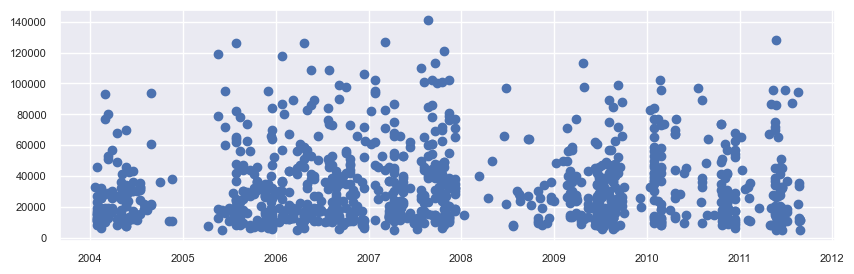

In [10]:
fig, ax = plt.subplots(figsize=(10,3))
ax.scatter(df.saledate[:1000], df.SalePrice[:1000]);

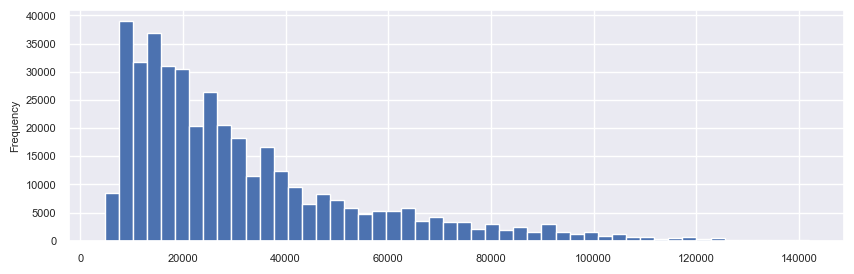

In [11]:
df.SalePrice.plot.hist(figsize=(10,3), bins=50);

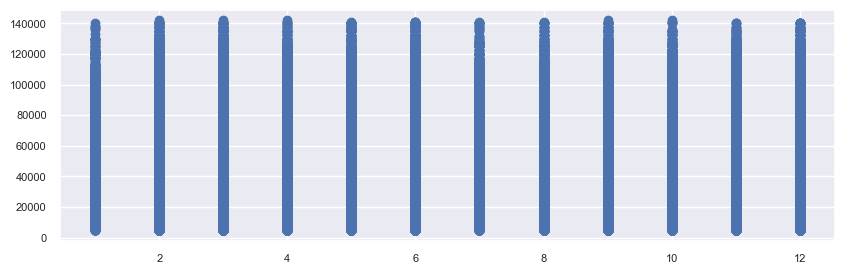

In [12]:
fig, ax = plt.subplots(figsize=(10,3))
ax.scatter(df.saledate.dt.month, df.SalePrice);

In [13]:
df.head().T

0  \
SalesID                                                    1139246   
SalePrice                                                    66000   
MachineID                                                   999089   
ModelID                                                       3157   
datasource                                                     121   
auctioneerID                                                   3.0   
YearMade                                                      2004   
MachineHoursCurrentMeter                                      68.0   
UsageBand                                                      Low   
saledate                                       2006-11-16 00:00:00   
fiModelDesc                                                   521D   
fiBaseModel                                                    521   
fiSecondaryDesc                                                  D   
fiModelSeries                                                  NaN   
fiModelDescriptor                                              NaN   
ProductSize                                                    NaN   
fiProductClassDesc        Wheel Loader - 110.0 to 120.0 Horsepower   
state                                                      Alabama   
ProductGroup                                                    WL   
ProductGroupDesc                                      Wheel Loader   
Drive_System                                                   NaN   
Enclosure                                               EROPS w AC   
Forks                                          None or Unspecified   
Pad_Type                                                       NaN   
Ride_Control                                   None or Unspecified   
Stick                                                          NaN   
Transmission                                                   NaN   
Turbocharged                                                   NaN   
Blade_Extension                                                NaN   
Blade_Width                                                    NaN   
Enclosure_Type                                                 NaN   
Engine_Horsepower                                              NaN   
Hydraulics                                                 2 Valve   
Pushblock                                                      NaN   
Ripper                                                         NaN   
Scarifier                                                      NaN   
Tip_Control                                                    NaN   
Tire_Size                                      None or Unspecified   
Coupler                                        None or Unspecified   
Coupler_System                                                 NaN   
Grouser_Tracks                                                 NaN   
Hydraulics_Flow                                                NaN   
Track_Type                                                     NaN   
Undercarriage_Pad_Width                                        NaN   
Stick_Length                                                   NaN   
Thumb                                                          NaN   
Pattern_Changer                                                NaN   
Grouser_Type                                                   NaN   
Backhoe_Mounting                                               NaN   
Blade_Type                                                     NaN   
Travel_Controls                                                NaN   
Differential_Type                                         Standard   
Steering_Controls                                     Conventional   

                                                                 1  \
SalesID                                                    1139248   
SalePrice                                                    57000   
MachineID                                                   117657   
Mode

### Sort DateFrame by `saledate`

When working with time series data, it is good idea to sort it by date.

In [14]:
# Sort df by saledate
df.sort_values(by='saledate', inplace=True, ascending=True)
df.tail()

SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  \
393123  6260878      13500    1799594     4102         149           2.0   
397987  6288376       9750    1872596     4875         149           2.0   
392664  6258093      14500    1877553     3170         149           2.0   
400458  6315563      12500    1869637    26456         149           2.0   
400217  6312170      11000    1812622     9580         149           2.0   

        YearMade  MachineHoursCurrentMeter UsageBand   saledate fiModelDesc  \
393123      1000                       NaN       NaN 2011-12-30         D4C   
397987      1000                       NaN       NaN 2011-12-30        520C   
392664      1988                       NaN       NaN 2011-12-30        580K   
400458      2010                       NaN       NaN 2011-12-30        L160   
400217      2005                       NaN       NaN 2011-12-30        T190   

       fiBaseModel fiSecondaryDesc fiModelSeries fiModelDescriptor  \
393123          D4               C           NaN               NaN   
397987         520               C           NaN               NaN   
392664         580               K           NaN               NaN   
400458        L160             NaN           NaN               NaN   
400217        T190             NaN           NaN               NaN   

       ProductSize  \
393123         NaN   
397987      Medium   
392664         NaN   
400458     Compact   
400217         NaN   

                                                fiProductClassDesc     state  \
393123         Track Type Tractor, Dozer - 75.0 to 85.0 Horsepower  New York   
397987                    Wheel Loader - 135.0 to 150.0 Horsepower  New York   
392664     Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth  New York   
400458                      Wheel Loader - 40.0 to 60.0 Horsepower  New York   
400217  Skid Steer Loader - 1751.0 to 2201.0 Lb Operating Capacity  New York   

       ProductGroup     ProductGroupDesc     Drive_System Enclosure  \
393123          TTT  Track Type Tractors              NaN     OROPS   
397987           WL         Wheel Loader              NaN     EROPS   
392664           BL      Backhoe Loaders  Two Wheel Drive     EROPS   
400458           WL         Wheel Loader              NaN     OROPS   
400217          SSL   Skid Steer Loaders              NaN     OROPS   

                      Forks             Pad_Type         Ride_Control  \
393123                  NaN                  NaN                  NaN   
397987  None or Unspecified                  NaN  None or Unspecified   
392664  None or Unspecified  None or Unspecified                   No   
400458  None or Unspecified                  NaN  None or Unspecified   
400217  None or Unspecified                  NaN                  NaN   

           Stick Transmission         Turbocharged Blade_Extension  \
393123       NaN     Standard                  NaN             NaN   
397987       NaN          NaN                  NaN             NaN   
392664  Extended     Standard  None or Unspecified             NaN   
400458       NaN          NaN                  NaN             NaN   
400217       NaN          NaN                  NaN             NaN   

       Blade_Width Enclosure_Type Engine_Horsepower Hydraulics Pushblock  \
393123         NaN            NaN               NaN    2 Valve       NaN   
397987         NaN            NaN               NaN    2 Valve       NaN   
392664         NaN            NaN               NaN        NaN       NaN   
400458         NaN            NaN               NaN    2 Valve       NaN   
400217         NaN            NaN               NaN  Auxiliary       NaN   

                     Ripper Scarifier Tip_Control            Tire_Size  \
393123  None or Unspecified       NaN         NaN                  NaN   
397987                  NaN       NaN         NaN  None or Unspecified   
392664                  NaN       NaN         NaN                  NaN   
4

### Make a copy of the original DataFrame

We make a copy original dataframe so when we manipulate the copy, we've still got our original data.

In [15]:
# Make a copy
tmp_df = df.copy(deep=True)

**Add datetime parameter for `saledate` column**

In [16]:
# Enrich our dataframe with new date derivated values
tmp_df['saleYear'] = tmp_df.saledate.dt.year
tmp_df['saleMonth'] = tmp_df.saledate.dt.month
tmp_df['saleDay'] = tmp_df.saledate.dt.day
tmp_df['saleDayofweek'] = tmp_df.saledate.dt.dayofweek
tmp_df['saleDayofyear'] = tmp_df.saledate.dt.dayofyear
tmp_df.drop(['saledate'], axis=1, inplace=True)

In [17]:
# Check the values of different columns
tmp_df.state.value_counts()

Florida           63944
Texas             51682
California        29019
Washington        15955
Georgia           14309
Maryland          12965
Mississippi       12961
Ohio              12190
Colorado          11254
Illinois          11209
New Jersey        10882
North Carolina    10404
Tennessee         10027
Alabama            9997
Pennsylvania       9941
South Carolina     9794
Arizona            9173
New York           8604
Connecticut        8128
Minnesota          7734
Missouri           6961
Nevada             6693
Louisiana          6450
Kentucky           5278
Maine              5095
Indiana            4086
Arkansas           3869
New Mexico         3529
Utah               2895
Unspecified        2801
New Hampshire      2724
Wisconsin          2668
Virginia           2288
Idaho              2018
Oregon             1775
Michigan           1763
Wyoming            1662
Montana            1327
Oklahoma           1311
Iowa               1215
West Virginia       746
Nebraska        

### Let's review the correlation

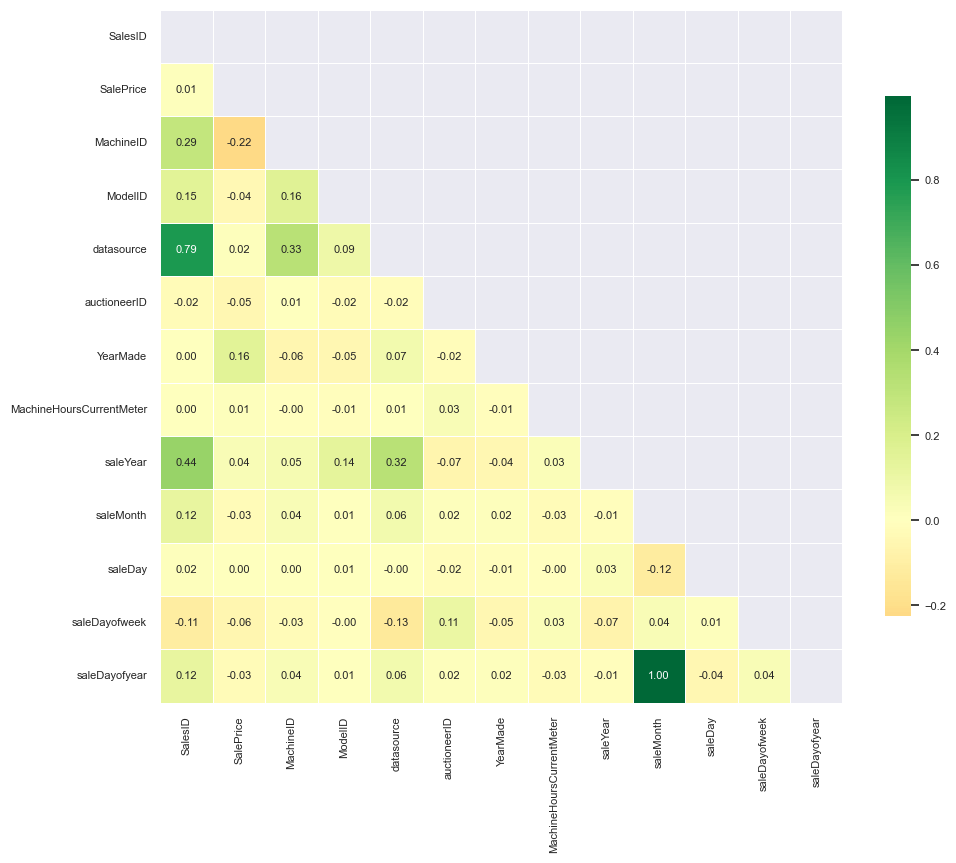

In [18]:
# Exploring the correlation
corr = tmp_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Let's make our correlation matrix more visual
fig, ax = plt.subplots(figsize=(11,9))
ax = sns.heatmap(corr, linewidths='.5', center=0, 
                 annot=True, fmt='.2f', annot_kws={'fontsize': 8},
                 mask=mask, cmap='RdYlGn', cbar_kws={"shrink": .75})

### Convert string into categories

In [19]:
# Which columns are string?
string_colummns = [label 
                   for label, content in tmp_df.items() 
                   if pd.api.types.is_string_dtype(content)]
print(string_colummns)

['UsageBand', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls', 'Differential_Type', 'Steering_Controls']


In [20]:
# Transforming the string columns into categories
for label, content in tmp_df.items():
    if pd.api.types.is_string_dtype(content):
        tmp_df[label] = content.astype('category').cat.as_ordered()
tmp_df.dtypes

SalesID                        int64
SalePrice                      int64
MachineID                      int64
ModelID                        int64
datasource                     int64
auctioneerID                 float64
YearMade                       int64
MachineHoursCurrentMeter     float64
UsageBand                   category
fiModelDesc                 category
fiBaseModel                 category
fiSecondaryDesc             category
fiModelSeries               category
fiModelDescriptor           category
ProductSize                 category
fiProductClassDesc          category
state                       category
ProductGroup                category
ProductGroupDesc            category
Drive_System                category
Enclosure                   category
Forks                       category
Pad_Type                    category
Ride_Control                category
Stick                       category
Transmission                category
Turbocharged                category
B

In [21]:
# Exploring categories
print(tmp_df.state.cat.categories)
tmp_df.state.cat.codes

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')


205615    43
92803      8
98346      8
169297     8
274835     8
          ..
393123    31
397987    31
392664    31
400458    31
400217    31
Length: 401125, dtype: int8

In [22]:
pd.Categorical(tmp_df.state)

['Texas', 'Florida', 'Florida', 'Florida', 'Florida', ..., 'New York', 'New York', 'New York', 'New York', 'New York']
Length: 401125
Categories (53, object): ['Alabama' < 'Alaska' < 'Arizona' < 'Arkansas' ... 'Washington DC' < 'West Virginia' < 'Wisconsin' < 'Wyoming']

In [23]:
# Check missing data
tmp_df.isnull().sum()/len(tmp_df)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.050199
YearMade                    0.000000
MachineHoursCurrentMeter    0.644089
UsageBand                   0.826391
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.342016
fiModelSeries               0.858129
fiModelDescriptor           0.820707
ProductSize                 0.525460
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.739829
Enclosure                   0.000810
Forks                       0.521154
Pad_Type                    0.802720
Ride_Control                0.629527
Stick                       0.802720
Transmission                0.543210
Turbocharged                0.802720
B

### Filling missing data

In [24]:
# Which numeric values has nulls
tmp_df.select_dtypes(include=[int, float]).isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    258360
saleYear                         0
saleMonth                        0
saleDay                          0
saleDayofweek                    0
saleDayofyear                    0
dtype: int64

In [25]:
# In training dataframe
tmp_df['auctioneerID_is_missing'] = tmp_df['auctioneerID'].isna()
tmp_df['MachineHoursCurrentMeter_is_missing'] = tmp_df['MachineHoursCurrentMeter'].isna()

fill_values = {'auctioneerID': tmp_df.auctioneerID.median(),
               'MachineHoursCurrentMeter': tmp_df.MachineHoursCurrentMeter.median()}
tmp_df.fillna(value=fill_values, inplace=True)
tmp_df.select_dtypes(include=[int, float]).isna().sum()

SalesID                     0
SalePrice                   0
MachineID                   0
ModelID                     0
datasource                  0
auctioneerID                0
YearMade                    0
MachineHoursCurrentMeter    0
saleYear                    0
saleMonth                   0
saleDay                     0
saleDayofweek               0
saleDayofyear               0
dtype: int64

In [26]:
# Demonstrate how median is more robust than mean
hundreds = np.full((1000,), 100)
hundreds_billion = np.append(hundreds, 1000000000)
hundreds.mean(), hundreds_billion.mean(), np.median(hundreds), np.median(hundreds_billion)

(100.0, 999100.8991008991, 100.0, 100.0)

In [27]:
# Which no numeric values has nulls
col_catego = tmp_df.select_dtypes(exclude=[int, float, bool])
col_catego

UsageBand fiModelDesc fiBaseModel fiSecondaryDesc fiModelSeries  \
205615       NaN        TD20        TD20             NaN           NaN   
92803        NaN         416         416             NaN           NaN   
98346        NaN         12G          12               G           NaN   
169297       NaN         644         644             NaN           NaN   
274835       NaN         A66         A66             NaN           NaN   
...          ...         ...         ...             ...           ...   
393123       NaN         D4C          D4               C           NaN   
397987       NaN        520C         520               C           NaN   
392664       NaN        580K         580               K           NaN   
400458       NaN        L160        L160             NaN           NaN   
400217       NaN        T190        T190             NaN           NaN   

       fiModelDescriptor ProductSize  \
205615               NaN      Medium   
92803                NaN         NaN   
98346                NaN         NaN   
169297               NaN      Medium   
274835               NaN         NaN   
...                  ...         ...   
393123               NaN         NaN   
397987               NaN      Medium   
392664               NaN         NaN   
400458               NaN     Compact   
400217               NaN         NaN   

                                                fiProductClassDesc     state  \
205615       Track Type Tractor, Dozer - 105.0 to 130.0 Horsepower     Texas   
92803      Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth   Florida   
98346                      Motorgrader - 130.0 to 145.0 Horsepower   Florida   
169297                    Wheel Loader - 175.0 to 200.0 Horsepower   Florida   
274835                    Wheel Loader - 120.0 to 135.0 Horsepower   Florida   
...                                                            ...       ...   
393123         Track Type Tractor, Dozer - 75.0 to 85.0 Horsepower  New York   
397987                    Wheel Loader - 135.0 to 150.0 Horsepower  New York   
392664     Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth  New York   
400458                      Wheel Loader - 40.0 to 60.0 Horsepower  New York   
400217  Skid Steer Loader - 1751.0 to 2201.0 Lb Operating Capacity  New York   

       ProductGroup     ProductGroupDesc     Drive_System Enclosure  \
205615          TTT  Track Type Tractors              NaN     OROPS   
92803            BL      Backhoe Loaders  Two Wheel Drive     EROPS   
98346            MG        Motor Graders               No     OROPS   
169297           WL         Wheel Loader              NaN     OROPS   
274835           WL         Wheel Loader              NaN     OROPS   
...             ...                  ...              ...       ...   
393123          TTT  Track Type Tractors              NaN     OROPS   
397987           WL         Wheel Loader              NaN     EROPS   
392664           BL      Backhoe Loaders  Two Wheel Drive     EROPS   
400458           WL         Wheel Loader              NaN     OROPS   
400217          SSL   Skid Steer Loaders              NaN     OROPS   

                      Forks             Pad_Type         Ride_Control  \
205615                  NaN                  NaN                  NaN   
92803   None or Unspecified  None or Unspecified                   No   
98346                   NaN                  NaN                  NaN   
169297  None or Unspecified                  NaN  None or Unspecified   
274835  None or Unspecified                  NaN  None or Unspecified   
...                     ...                  ...                  ...   
393123                  NaN                  NaN                  NaN   
397987  None or Unspecified                  NaN  None or Unspecified   
392664  None or Unspecified  None or Unspecified                   No   
400458  None or Unspecified                  NaN  None or Unspecified   
400217  None or Unsp

In [28]:
for label in col_catego.columns:
    tmp_df[label+'_is_missing'] = tmp_df[label].isna()
    tmp_df[label] = tmp_df[label].cat.codes + 1
tmp_df.head()

SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  \
205615  1646770       9500    1126363     8434         132          18.0   
92803   1404019      24000    1169900     7110         132          99.0   
98346   1415646      35000    1262088     3357         132          99.0   
169297  1596358      19000    1433229     8247         132          99.0   
274835  1821514      14000    1194089    10150         132          99.0   

        YearMade  MachineHoursCurrentMeter  UsageBand  fiModelDesc  \
205615      1974                       0.0          0         4537   
92803       1986                       0.0          0          735   
98346       1975                       0.0          0           82   
169297      1978                       0.0          0         1158   
274835      1980                       0.0          0         1800   

        fiBaseModel  fiSecondaryDesc  fiModelSeries  fiModelDescriptor  \
205615         1735                0              0                  0   
92803           243                0              0                  0   
98346            19               57              0                  0   
169297          349                0              0                  0   
274835          557                0              0                  0   

        ProductSize  fiProductClassDesc  state  ProductGroup  \
205615            4                  47     44             5   
92803             0                   2      9             1   
98346             0                  31      9             2   
169297            4                  63      9             6   
274835            0                  60      9             6   

        ProductGroupDesc  Drive_System  Enclosure  Forks  Pad_Type  \
205615                 5             0          6      0         0   
92803                  1             4          1      1         2   
98346                  2             3          6      0         0   
169297                 6             0          6      1         0   
274835                 6             0          6      1         0   

        Ride_Control  Stick  Transmission  Turbocharged  Blade_Extension  \
205615             0      0             3             0                0   
92803              1      2             8             1                0   
98346              0      0             5             0                1   
169297             2      0             0             0                0   
274835             2      0             0             0                0   

        Blade_Width  Enclosure_Type  Engine_Horsepower  Hydraulics  Pushblock  \
205615            0               0                  0           1          0   
92803             0               0                  0           0          0   
98346             1               3                  1           5          1   
169297            0               0                  0           1          0   
274835            0               0                  0           1          0   

        Ripper  Scarifier  Tip_Control  Tire_Size  Coupler  Coupler_System  \
205615       2          0            0          0        0               0   
92803        0          0            0          0        0               0   
98346        2          2            2          4        0               0   
169297       0          0            0         17        3               0   
274835       0          0            0         17        3               0   

        Grouser_Tracks  Hydraulics_Flow  Track_Type  Undercarriage_Pad_Width  \
205615               0                0           0                        0   
92803                0                0           0                        0   
98346                0                0           0                        0   
169297               0                0           0                        0   
274835               0                0           0               

In [29]:
print(tmp_df.shape)
tmp_df.info()

(401125, 103)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 401125 entries, 205615 to 400217
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(2), int16(4), int64(11), int8(40)
memory usage: 78.8 MB


In [30]:
tmp_df.isna().sum().sum()

0

In [31]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401125 entries, 205615 to 400217
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(2), int16(4), int64(11), int8(40)
memory usage: 78.8 MB


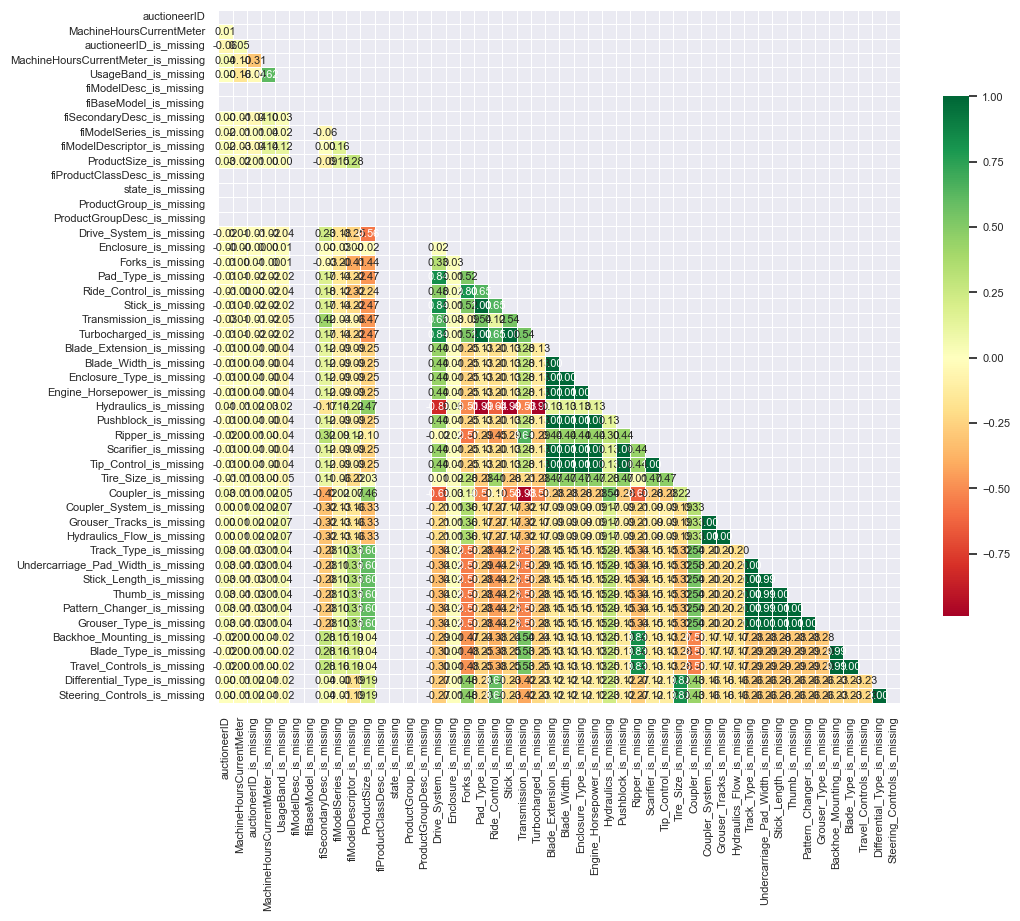

In [32]:
# Exploring the correlation
corr = tmp_df.select_dtypes(include=[bool, float]).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Let's make our correlation matrix more visual
fig, ax = plt.subplots(figsize=(11,9))
ax = sns.heatmap(corr, linewidths='.5', center=0, 
                 annot=True, fmt='.2f', annot_kws={'fontsize': 8},
                 mask=mask, cmap='RdYlGn', cbar_kws={"shrink": .75})

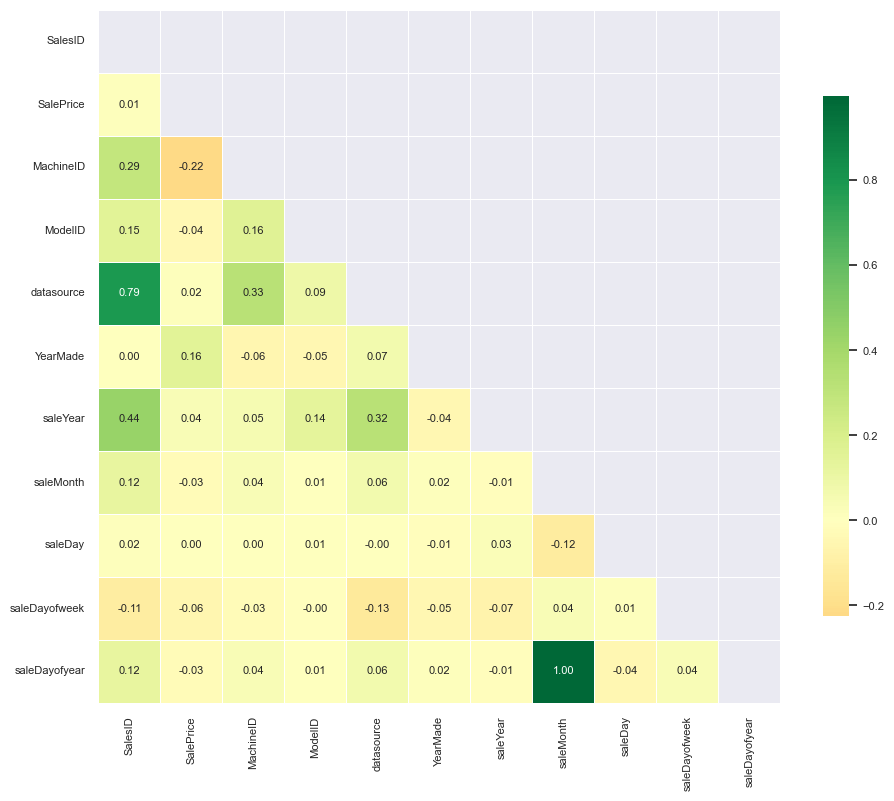

In [33]:
# Exploring the correlation
corr = tmp_df.select_dtypes(include=[int]).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Let's make our correlation matrix more visual
fig, ax = plt.subplots(figsize=(11,9))
ax = sns.heatmap(corr, linewidths='.5', center=0, 
                 annot=True, fmt='.2f', annot_kws={'fontsize': 8},
                 mask=mask, cmap='RdYlGn', cbar_kws={"shrink": .75})

## 5. Modeling

In [34]:
tmp_df.saleYear.value_counts().sort_index(ascending=False)

2011    35197
2010    33390
2009    43849
2008    39767
2007    32208
2006    21685
2005    20463
2004    19879
2003    15254
2002    17246
2001    17594
2000    17415
1999    12793
1998    13046
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1990     4529
1989     4806
Name: saleYear, dtype: int64

In [35]:
# Set the random seed
np.random.seed(42)

# Split into Training & Testing
Xy_train = tmp_df[tmp_df.saleYear<2011]
Xy_test = tmp_df[tmp_df.saleYear==2011]

X_train, y_train = Xy_train.drop(['SalePrice'], axis=1), Xy_train.SalePrice
X_test, y_test = Xy_test.drop(['SalePrice'], axis=1), Xy_test.SalePrice

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((365928, 102), (365928,), (35197, 102), (35197,))

In [36]:
%%time
# This take far too long ... for experiment

# Let's build a Machine Learning model.
model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(X_train, y_train)
model.score(X_test, y_test)

CPU times: total: 18min 4s
Wall time: 2min 46s


0.857915133698124

**Building our own evaluation fuction**

In [37]:
# Create evaluation function (RMSLE)
def rmsle(y_true, y_pred):
    """
    Calculate root mean squared log error between predictions 
    and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def show_scores(model, X_train, y_train, X_test, y_test):
    """
    Evaluate model and show results on different scores metrics
    and levels
    """
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    scores = {
        'Training score': model.score(X_train, y_train),
        'Training R^2': r2_score(y_train, train_preds),
        'Training MAE': mean_absolute_error(y_train, train_preds),
        'Training MSE': mean_squared_error(y_train, train_preds),
        'Training MSLE': mean_squared_log_error(y_train, train_preds),
        'Training RMSLE': rmsle(y_train, train_preds),
        
        'Testing score': model.score(X_test, y_test),
        'Testing R^2': r2_score(y_test, test_preds),
        'Testing MAE': mean_absolute_error(y_test, test_preds),
        'Testing MSE': mean_squared_error(y_test, test_preds),
        'Testing MSLE': mean_squared_log_error(y_test, test_preds),
        'Testing RMSLE': rmsle(y_test, test_preds)
    }
    return scores

In [38]:
# Evaluate the model
scores = show_scores(model, X_train, y_train, X_test, y_test)
scores

{'Training score': 0.9873928990860119,
 'Training R^2': 0.9873928990860119,
 'Training MAE': 1573.0540429811333,
 'Training MSE': 6573817.635753778,
 'Training MSLE': 0.007156034378277432,
 'Training RMSLE': 0.08459334712775841,
 'Testing score': 0.857915133698124,
 'Testing R^2': 0.857915133698124,
 'Testing MAE': 5954.90849220104,
 'Testing MSE': 87866028.31481762,
 'Testing MSLE': 0.06152236692638707,
 'Testing RMSLE': 0.2480370273293628}

## 6. Experiments

### Testing our model on a subset to tune hyperparameters

In [39]:
# Change max sample values
model = RandomForestRegressor(n_jobs=-1, random_state=42, 
                              bootstrap=True, max_samples=10000)

In [40]:
%%time

# Cutting down on the max number of samples each estimator can see improves in time consumption
model.fit(X_train, y_train)

CPU times: total: 33.8 s
Wall time: 5.26 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [41]:
# Evaluate the model with max_samples
scores = show_scores(model, X_train, y_train, X_test, y_test)
print(scores['Testing RMSLE'])
scores

0.28626881763659495


{'Training score': 0.8628737214812484,
 'Training R^2': 0.8628737214812484,
 'Training MAE': 5466.196100708335,
 'Training MSE': 71502810.53526482,
 'Training MSLE': 0.06552770977399358,
 'Training RMSLE': 0.2559838076402365,
 'Testing score': 0.8179884804991473,
 'Testing R^2': 0.8179884804991473,
 'Testing MAE': 6887.866919339716,
 'Testing MSE': 112556880.56254126,
 'Testing MSLE': 0.08194983595105405,
 'Testing RMSLE': 0.28626881763659495}

### Hyperparameter tuning with RandomizedSearchCV

In [42]:
%%time

# RandomForestRegressor Hyperparameter
rf_grid = {'n_estimators': [64, 100, 128],
           'max_depth': [None, 8, 16, 64],
           'min_samples_split': [2, 3, 5, 10],
           'min_samples_leaf': [1, 2, 3, 5],
           'max_features': ['sqrt', None, 1],
           'max_samples': [10000]}

# Initiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42), rf_grid, 
                              n_iter=10, verbose=True)

# Fint the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: total: 1min 59s
Wall time: 3min 29s


RandomizedSearchCV(estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   param_distributions={'max_depth': [None, 8, 16, 64],
                                        'max_features': ['sqrt', None, 1],
                                        'max_samples': [10000],
                                        'min_samples_leaf': [1, 2, 3, 5],
                                        'min_samples_split': [2, 3, 5, 10],
                                        'n_estimators': [64, 100, 128]},
                   verbose=True)

In [43]:
# Evaluate the best model found by RandomizedSearchCV
scores = show_scores(rs_model, X_train, y_train, X_test, y_test)
print(scores['Testing RMSLE'])

import pprint
pprint.pprint(scores)

# Find the best parameters
rs_model.best_params_

0.28568494715886017
{'Testing MAE': 6923.070633587085,
 'Testing MSE': 115534046.93413381,
 'Testing MSLE': 0.08161588903316074,
 'Testing RMSLE': 0.28568494715886017,
 'Testing R^2': 0.8131742161699284,
 'Testing score': 0.8131742161699284,
 'Training MAE': 5523.213465105469,
 'Training MSE': 73675459.02765137,
 'Training MSLE': 0.06656903129217237,
 'Training RMSLE': 0.25800975038198143,
 'Training R^2': 0.8587070712466621,
 'Training score': 0.8587070712466621}


{'n_estimators': 64,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_samples': 10000,
 'max_features': None,
 'max_depth': 64}

### Train a model with the best hyperparameters

**Note:** These hyperparameters were found after 50 iterations of `RandomizedSearchCV`.

Hyperparameters showed in the course:
* **n_estimator**=40,
* **min_samples_leaf**=1,
* **min_samples_split**=14,
* **max_features**=0.5,
* **n_jobs**=1,
* **max_samples**=None

In [44]:
# Getting the best found parameters
best_found_parameters = rs_model.best_params_
_ = best_found_parameters.pop('max_samples')
best_found_parameters

{'n_estimators': 64,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': None,
 'max_depth': 64}

In [45]:
%%time

# Most ideal found parameters
best_found_model = RandomForestRegressor(**best_found_parameters, 
                                         max_samples=None, random_state=42, n_jobs=-1)
best_found_model.fit(X_train, y_train)

CPU times: total: 11min 54s
Wall time: 2min 7s


RandomForestRegressor(max_depth=64, max_features=None, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=64, n_jobs=-1,
                      random_state=42)

In [46]:
# Evaluate the best model 
scores = show_scores(best_found_model, X_train, y_train, X_test, y_test)
print(scores['Testing RMSLE'])

import pprint
pprint.pprint(scores)

0.24798262286054923
{'Testing MAE': 5958.677254790529,
 'Testing MSE': 88579402.9531197,
 'Testing MSLE': 0.0614953812407974,
 'Testing RMSLE': 0.24798262286054923,
 'Testing R^2': 0.8567615622661351,
 'Testing score': 0.8567615622661351,
 'Training MAE': 2043.1649634021662,
 'Training MSE': 11999298.774307482,
 'Training MSLE': 0.011926368453566314,
 'Training RMSLE': 0.10920791387791598,
 'Training R^2': 0.9769880488132157,
 'Training score': 0.9769880488132157}


### Make predictions on test data

In [47]:
df_test.head()

SalesID  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1227829    1006309     3168         121             3      1999   
1  1227844    1022817     7271         121             3      1000   
2  1227847    1031560    22805         121             3      2004   
3  1227848      56204     1269         121             3      2006   
4  1227863    1053887    22312         121             3      2005   

   MachineHoursCurrentMeter UsageBand   saledate fiModelDesc fiBaseModel  \
0                    3688.0       Low 2012-05-03        580G         580   
1                   28555.0      High 2012-05-10         936         936   
2                    6038.0    Medium 2012-05-10    EC210BLC       EC210   
3                    8940.0      High 2012-05-10       330CL         330   
4                    2286.0       Low 2012-05-10        650K         650   

  fiSecondaryDesc fiModelSeries fiModelDescriptor     ProductSize  \
0               G           NaN               NaN             NaN   
1             NaN           NaN               NaN          Medium   
2               B           NaN                LC  Large / Medium   
3               C           NaN                 L  Large / Medium   
4               K           NaN               NaN             NaN   

                                        fiProductClassDesc       state  \
0  Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth     Wyoming   
1                 Wheel Loader - 135.0 to 150.0 Horsepower    Virginia   
2    Hydraulic Excavator, Track - 21.0 to 24.0 Metric Tons  New Jersey   
3    Hydraulic Excavator, Track - 33.0 to 40.0 Metric Tons  New Jersey   
4      Track Type Tractor, Dozer - 20.0 to 75.0 Horsepower     Florida   

  ProductGroup     ProductGroupDesc     Drive_System   Enclosure Forks  \
0           BL      Backhoe Loaders  Two Wheel Drive       OROPS   Yes   
1           WL         Wheel Loader              NaN       EROPS   Yes   
2          TEX     Track Excavators              NaN  EROPS w AC   NaN   
3          TEX     Track Excavators              NaN  EROPS w AC   NaN   
4          TTT  Track Type Tractors              NaN       OROPS   NaN   

              Pad_Type         Ride_Control     Stick Transmission  \
0  None or Unspecified                   No  Standard     Standard   
1                  NaN  None or Unspecified       NaN          NaN   
2                  NaN                  NaN       NaN          NaN   
3                  NaN                  NaN       NaN          NaN   
4                  NaN                  NaN       NaN  Hydrostatic   

          Turbocharged Blade_Extension Blade_Width Enclosure_Type  \
0  None or Unspecified             NaN         NaN            NaN   
1                  NaN             NaN         NaN            NaN   
2                  NaN             NaN         NaN            NaN   
3                  NaN             NaN         NaN            NaN   
4                  NaN             NaN         NaN            NaN   

  Engine_Horsepower Hydraulics Pushblock               Ripper Scarifier  \
0               NaN        NaN       NaN                  NaN       NaN   
1               NaN    2 Valve       NaN                  NaN       NaN   
2               NaN  Auxiliary       NaN                  NaN       NaN   
3               NaN   Standard       NaN                  NaN       NaN   
4               NaN    2 Valve       NaN  None or Unspecified       NaN   

  Tip_Control Tire_Size              Coupler Coupler_System Grouser_Tracks  \
0         NaN       NaN                  NaN            NaN            NaN   
1         NaN      20.5  None or Unspecified            NaN            NaN   
2         NaN       NaN  None or Unspecified            NaN            NaN   
3         NaN       NaN  None or Unspecified            NaN            NaN   
4         NaN       NaN                  NaN            NaN            NaN   

  Hydraulics_Flow Track_Type Undercarriage_Pad_Width         Sti

In [48]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

In [49]:
# Get the test dataset in the same format as the train dataset.
def preprocess_data(df):
    """
    Performs transformation on df and returns transformed df.
    """
    df = df.copy(deep=True)
    df.sort_values(by='saledate', inplace=True, ascending=True)
    df['saleYear'] = df.saledate.dt.year
    df['saleMonth'] = df.saledate.dt.month
    df['saleDay'] = df.saledate.dt.day
    df['saleDayofweek'] = df.saledate.dt.dayofweek
    df['saleDayofyear'] = df.saledate.dt.dayofyear
    df.drop(['saledate'], axis=1, inplace=True)

    # Transform numerical features
    df['auctioneerID_is_missing'] = df['auctioneerID'].isna()
    df['MachineHoursCurrentMeter_is_missing'] = df['MachineHoursCurrentMeter'].isna()
    df.fillna(df[['auctioneerID', 'MachineHoursCurrentMeter']].median(), inplace=True)
    
    # Transform categorical features
    #df[df.select_dtypes(['object']).columns] = \
    #    df.select_dtypes(['object']).apply(lambda x: x.astype('category').cat.as_ordered())
    #for label, content in df.select_dtypes(['category']).items():
    #    df[label+'_is_missing'] = df[label].isna()
    #    df[label] = df[label].cat.codes + 1
    for col in df.select_dtypes(['object']).columns:
        df[col+'_is_missing'] = df[col].isna()
        df[col] = pd.Categorical(df[col]).codes + 1
    return df

In [55]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401125 entries, 205615 to 400217
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(2), int16(4), int64(11), int8(40)
memory usage: 78.8 MB


In [56]:
df_test_transformed = preprocess_data(df_test)
print(df_test_transformed.info())
df_test_transformed.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12457 entries, 1408 to 9803
Columns: 102 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(1), int16(2), int64(11), int8(42)
memory usage: 2.3 MB
None


SalesID  MachineID  ModelID  datasource  auctioneerID  YearMade  \
1408  4317459    2295526     8132         172             1      1998   
1023  4249784    1745722     3178         172             1      1995   
1728  4392603    2283116    18111         172             1      2004   
1167  4274831    2288988     3783         172             1      2001   
1594  4362801    2300591    16490         172             1      2006   

      MachineHoursCurrentMeter  UsageBand  fiModelDesc  fiBaseModel  \
1408                    4359.0          3          397          148   
1023                    4489.0          2          509          180   
1728                    2126.0          2          906          320   
1167                    9115.0          3          824          290   
1594                     885.0          2         1513          610   

      fiSecondaryDesc  fiModelSeries  fiModelDescriptor  ProductSize  \
1408                0              0                  0            0   
1023               60              0                  0            0   
1728                0              0                  0            0   
1167               25              0                  0            0   
1594               41              9                  0            5   

      fiProductClassDesc  state  ProductGroup  ProductGroupDesc  Drive_System  \
1408                  42      3             3                 3             0   
1023                   2      3             1                 1             2   
1728                   1      3             1                 1             4   
1167                  56      3             6                 6             0   
1594                   6      3             4                 4             0   

      Enclosure  Forks  Pad_Type  Ride_Control  Stick  Transmission  \
1408          3      1         0             0      0             0   
1023          2      1         2             1      1             7   
1728          2      1         2             3      1             7   
1167          2      2         0             3      0             0   
1594          1      0         0             0      0             0   

      Turbocharged  Blade_Extension  Blade_Width  Enclosure_Type  \
1408             0                0            0               0   
1023             1                0            0               0   
1728             1                0            0               0   
1167             0                0            0               0   
1594             0                0            0               0   

      Engine_Horsepower  Hydraulics  Pushblock  Ripper  Scarifier  \
1408                  0           4          0       0          0   
1023                  0           0          0       0          0   
1728                  0           0          0       0          0   
1167                  0           1          0       0          0   
1594                  0           4          0       0          0   

      Tip_Control  Tire_Size  Coupler  Coupler_System  Grouser_Tracks  \
1408            0          0        3               1               1   
1023            0          0        0               0               0   
1728            0          0        0               0               0   
1167            0          7        3               0               0   
1594            0          0        3               0               0   

      Hydraulics_Flow  Track_Type  Undercarriage_Pad_Width  Stick_Length  \
1408                3           0                        0             0   
1023                0           0                        0             0   
1728                0           0                        0             0   
1167                0           0                        0             0   
1594                0           2                       17            20   

      Thumb  Pattern_Changer  Grouser_Type  Backhoe_Mounting  Blade_Type 

In [70]:
# Validat that df_test_transformed has same colums as tmp_df
print(set(tmp_df.columns) == set(df_test_transformed.columns).union({'SalePrice'}))
set(tmp_df.columns) - set(df_test_transformed.columns)

True


{'SalePrice'}

In [75]:
# Make prediction on this transformed test data
test_preds = best_found_model.predict(df_test_transformed)

df_preds = pd.DataFrame({
    'SalesID': df_test_transformed.SalesID,
    'SalePrice': test_preds
})
df_preds.to_csv('data/lesson-bulldozer-predicted-price.csv', index=False)
df_preds.head()

SalesID     SalePrice
1408  4317459  10302.644469
1023  4249784  17546.919953
1728  4392603  24931.085689
1167  4274831  28310.906498
1594  4362801  11694.912574

## FEATURE IMPORTANCE

Feature importance seeks to figure our which different attributes of the data were most importance when it comes to predicting the **target variable** (SalePrice).

Why might knowing the feature importances of a trained machine learning model be helpful?

In [93]:
# Find features importance
pd.set_option('display.max_rows', None)
df_features = pd.DataFrame({
    'Feature': best_found_model.feature_names_in_,
    'Weight': best_found_model.feature_importances_ 
}).sort_values(['Weight'], ascending=False).reset_index(drop=True)
df_features

Feature        Weight
0                               YearMade  2.678576e-01
1                            ProductSize  2.267160e-01
2                            fiBaseModel  8.580617e-02
3                               saleYear  7.835243e-02
4                                SalesID  5.431217e-02
5                        fiSecondaryDesc  5.128406e-02
6                     fiProductClassDesc  4.292592e-02
7                                ModelID  3.059161e-02
8                            fiModelDesc  1.868796e-02
9                         Coupler_System  1.570520e-02
10                             MachineID  1.524600e-02
11             Coupler_System_is_missing  1.474052e-02
12                         saleDayofyear  1.411587e-02
13                             Enclosure  9.374064e-03
14                               saleDay  8.217797e-03
15                                 state  8.014718e-03
16                            Hydraulics  7.016708e-03
17                 Hydraulics_is_missing  5.219781e-03
18                          auctioneerID  4.037489e-03
19                         saleDayofweek  3.982678e-03
20                         fiModelSeries  3.958360e-03
21                     fiModelDescriptor  2.816606e-03
22                             saleMonth  2.774335e-03
23              MachineHoursCurrentMeter  2.234773e-03
24                             Pushblock  2.065966e-03
25                                Ripper  2.053461e-03
26                ProductSize_is_missing  1.951379e-03
27                          Drive_System  1.849268e-03
28                             Tire_Size  1.597667e-03
29                            Blade_Type  1.463670e-03
30                          Transmission  1.307725e-03
31                          Stick_Length  1.272847e-03
32               Undercarriage_Pad_Width  1.103559e-03
33            fiSecondaryDesc_is_missing  8.406210e-04
34                               Coupler  8.175675e-04
35                             UsageBand  7.841865e-04
36                       Travel_Controls  7.125667e-04
37                                 Thumb  6.834041e-04
38                             Scarifier  6.312525e-04
39          fiModelDescriptor_is_missing  5.927950e-04
40              fiModelSeries_is_missing  5.519580e-04
41                          Ride_Control  4.159620e-04
42                          Grouser_Type  3.902290e-04
43   MachineHoursCurrentMeter_is_missing  3.757144e-04
44                  Tire_Size_is_missing  3.556811e-04
45                                 Forks  3.254348e-04
46                      Backhoe_Mounting  2.711251e-04
47                            datasource  2.652105e-04
48                           Blade_Width  2.615468e-04
49                       Pattern_Changer  2.255317e-04
50               auctioneerID_is_missing  2.251849e-04
51           Backhoe_Mounting_is_missing  1.897968e-04
52                          ProductGroup  1.713061e-04
53                           Tip_Control  1.611846e-04
54                  UsageBand_is_missing  1.600214e-04
55                     Differential_Type  1.600194e-04
56                            Track_Type  1.521378e-04
57                                 Stick  1.466859e-04
58                        Enclosure_Type  1.446811e-04
59                     Steering_Controls  1.445499e-04
60                      ProductGroupDesc  1.302433e-04
61                 Blade_Type_is_missing  1.231984e-04
62                    Coupler_is_missing  9.365064e-05
63            Travel_Controls_is_missing  8.334551e-05
64               Transmission_is_missing  7.766832e-05
65                      Forks_is_missing  6.754876e-05
66          Differential_Type_is_missing  5.685198e-05
67          Steering_Controls_is_missing  5.663539e-05
68               Ride_Control_is_missing  5.310926e-05
69                     Engine_Horsepower  5.208272e-05
70            Blade_Extension_is_missing  4.368692e-05
71                     Ripper_is_missing  4.366856e-05
72                

In [111]:
# Helper funtion for plotting feature importance
def plot_features(features, weights, n=20, figsize=(10,3)):
    # Organize data
    dfwf = pd.DataFrame({
        'Feature': features,
        'Weight': weights 
    }).sort_values(['Weight'], ascending=False).reset_index(drop=True)
    
    # Plot most important features
    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(dfwf.Feature[:n], dfwf.Weight[:n])
    ax.set_ylabel('Features')
    ax.invert_yaxis()
    ax.set_xlabel('Weights')
    fig.suptitle('Feature Weight')
    plt.tight_layout()
    return dfwf.iloc[:n]

Feature    Weight
0                    YearMade  0.267858
1                 ProductSize  0.226716
2                 fiBaseModel  0.085806
3                    saleYear  0.078352
4                     SalesID  0.054312
5             fiSecondaryDesc  0.051284
6          fiProductClassDesc  0.042926
7                     ModelID  0.030592
8                 fiModelDesc  0.018688
9              Coupler_System  0.015705
10                  MachineID  0.015246
11  Coupler_System_is_missing  0.014741
12              saleDayofyear  0.014116
13                  Enclosure  0.009374
14                    saleDay  0.008218
15                      state  0.008015
16                 Hydraulics  0.007017
17      Hydraulics_is_missing  0.005220
18               auctioneerID  0.004037
19              saleDayofweek  0.003983

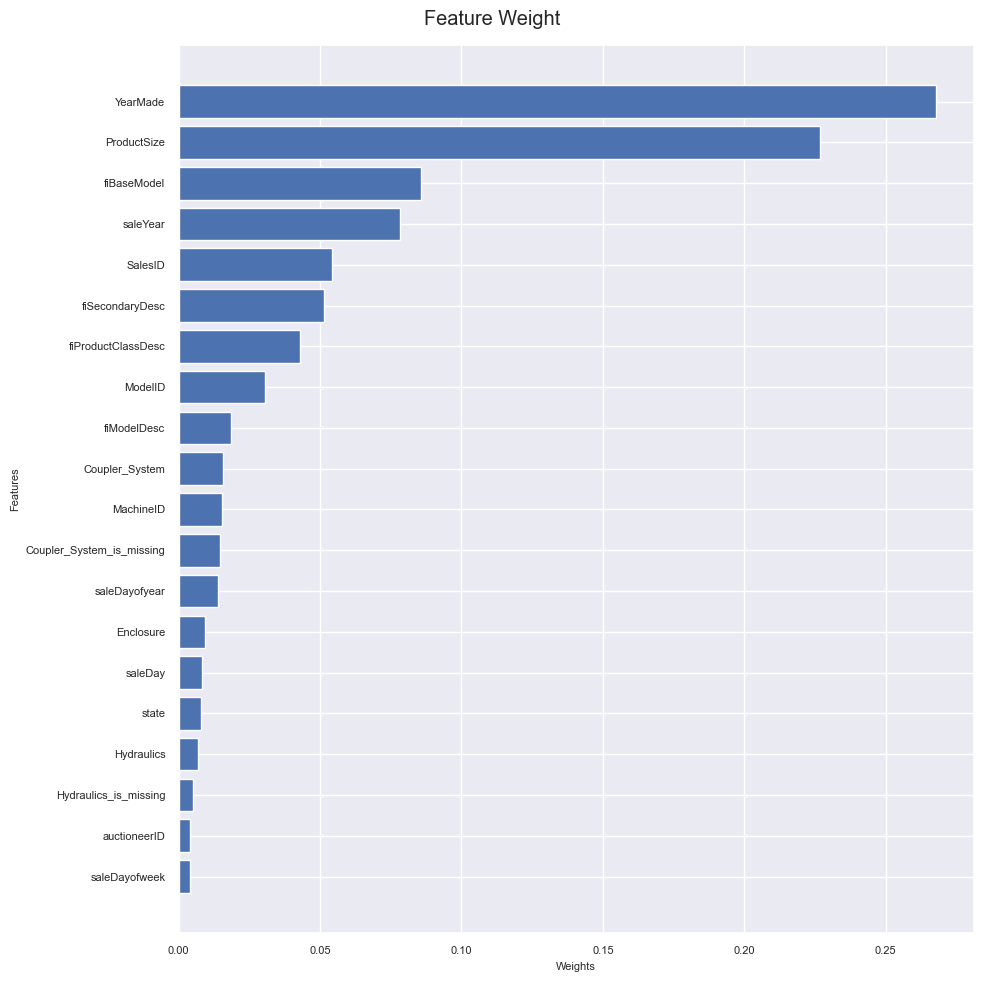

In [114]:
plot_features(best_found_model.feature_names_in_, best_found_model.feature_importances_, 
              n=20, figsize=(10,10))

# Appendice

**Testing how to fill on multiples columns**

In [58]:
dfe = pd.DataFrame({
    'a': [1, None, 1, 1],
    'b': [2, 2, None, 2],
    'c': [None, 3, 3, 3]
})
dfe

a    b    c
0  1.0  2.0  NaN
1  NaN  2.0  3.0
2  1.0  NaN  3.0
3  1.0  2.0  3.0

In [59]:
dfe.median()

a    1.0
b    2.0
c    3.0
dtype: float64

In [60]:
dfe.fillna(dfe[['a','b']].median(), inplace=True)
dfe

a    b    c
0  1.0  2.0  NaN
1  1.0  2.0  3.0
2  1.0  2.0  3.0
3  1.0  2.0  3.0

**How to transform multiples columns into categories**

In [61]:
dfe = pd.DataFrame({
    'a': ['a', 'b', 'c', 'd'],
    'b': ['e', 'f', 'g', 'h'],
    'c': [1, 2, 3, 4]
})
dfe = dfe.select_dtypes(include=['object']).astype('category')
dfe

a  b
0  a  e
1  b  f
2  c  g
3  d  h